<a href="https://colab.research.google.com/github/jihyoung-lee/stock_news_classifier/blob/main/stock_news_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system ==

In [ ]:
!pip install --upgrade transformers

In [ ]:
pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 124.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
te

In [ ]:
!pip cache purge

Files removed: 24


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import pandas as pd
import numpy as np
import evaluate
from datasets import Dataset, DatasetDict

# model 과 tokenizer 불러오기
model_name = "klue/bert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True,
    )

# data-set 로드(csv)
#dataset = load_dataset('csv', data_files='/content/final_dataset.csv')
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
})
# 전처리 함수
def preprocess_function(examples):
    tokenized_inputs = tokenizer(examples["title"], padding='max_length', truncation=True)
    tokenized_inputs["labels"] = examples["label"]
    return tokenized_inputs
# 전처리
tokenized_dataset = dataset.map(preprocess_function, batched=True)

# 훈련설정
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    report_to="none",
    logging_steps=10,
)
# 정확도 metric 불러오기
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=preds, references=labels)

# 훈련
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

Step,Training Loss
10,0.701700
20,0.686800
30,0.571700
40,0.446300
50,0.482800
60,0.421000
70,0.354400
80,0.270900
90,0.170500
100,0.147300


TrainOutput(global_step=360, training_loss=0.21139840049048264, metrics={'train_runtime': 279.6488, 'train_samples_per_second': 10.227, 'train_steps_per_second': 1.287, 'total_flos': 752497618329600.0, 'train_loss': 0.21139840049048264, 'epoch': 5.0})

In [ ]:
print(trainer.evaluate())

{'eval_loss': 0.5341475009918213, 'eval_accuracy': 0.8958333333333334, 'eval_runtime': 4.2467, 'eval_samples_per_second': 33.909, 'eval_steps_per_second': 4.239, 'epoch': 5.0}


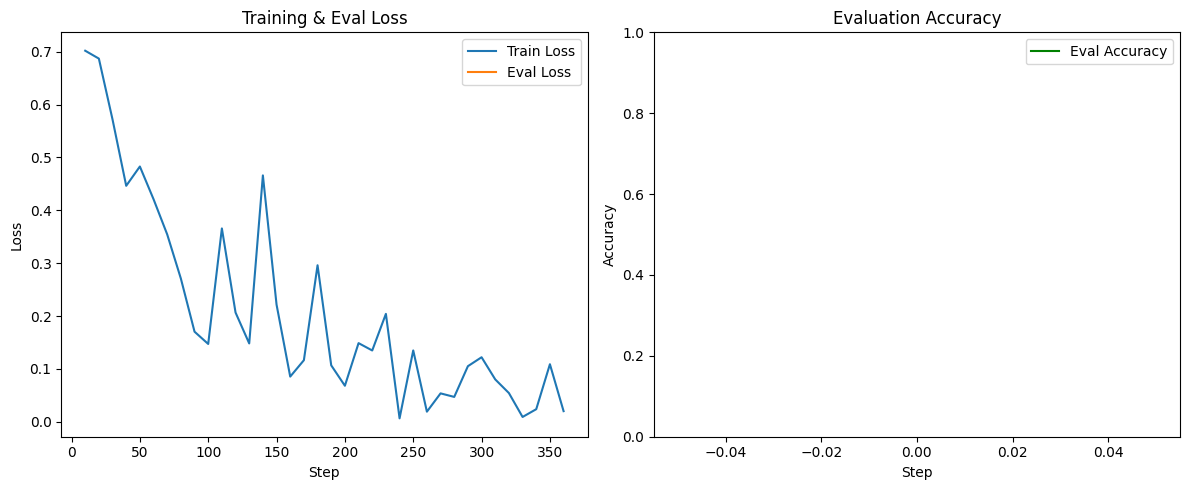

In [ ]:
# 시각화
import json
import matplotlib.pyplot as plt

# 로그 파일 열기
with open('./results/trainer_state.json', 'r', encoding='utf-8') as f:
    log_data = json.load(f)

# 로그에서 step별 로그 추출
log_history = log_data['log_history']

# loss, accuracy, step 리스트 만들기
train_steps, train_loss = [], []
eval_steps, eval_loss, eval_accuracy = [], [], []

for entry in log_history:
    if 'loss' in entry:
        train_steps.append(entry['step'])
        train_loss.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_steps.append(entry['step'])
        eval_loss.append(entry['eval_loss'])
        eval_accuracy.append(entry['eval_accuracy'])

# 📊 그래프 그리기
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss')
plt.plot(eval_steps, eval_loss, label='Eval Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training & Eval Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(eval_steps, eval_accuracy, label='Eval Accuracy', color='green')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Evaluation Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# 모델 저장
trainer.save_model("./my_model")
tokenization.save_pretrained("./my_model")

('./my_model/tokenizer_config.json',
 './my_model/special_tokens_map.json',
 './my_model/vocab.txt',
 './my_model/added_tokens.json')

In [ ]:
# 모델 압축 해제
import os
import zipfile

zip_path = "/content/mymodel.zip"
model_path = "/content/mymodel"
# 폴더 없으면 생성
os.makedirs(model_path, exist_ok=True)
# 압축 풀기
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(model_path)


In [ ]:
# 모델 불러오기
from transformers import BertTokenizer, BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)

HFValidationError: Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: './my_model'.

In [ ]:
# 예측하기
model_path = "./my_model"
model = BertForSequenceClassification.from_pretrained(model_path, local_files_only=True)
tokenizer = BertTokenizer.from_pretrained(model_path, local_files_only=True)

text = "삼성전자 폭락 금융 엄청난 위기"

# 입력 전처리
input = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

# 예측
output = model(**input)
logits = output.logits

#확률로 변환
import torch
probs = torch.softmax(logits, dim=1)

PRBBL_PSTV = probs[0][1].item()
PRBBL_NGTV = probs[0][0].item()
# 결과 출력
print(f"호재 확률: {PRBBL_PSTV:.2f}")
print(f"악재 확률: {PRBBL_NGTV:.2f}")

호재 확률: 0.22
악재 확률: 0.78
